<a href="https://colab.research.google.com/github/sriyamistry0-lang/GenTen/blob/main/NETosis_Analyzer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install GEOparse gseapy pandas seaborn matplotlib scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 605.3/605.3 kB 19.2 MB/s eta 0:00:00


In [4]:
!pip uninstall -y scipy
!pip install scipy==1.11.4
!pip install GEOparse gseapy pandas seaborn matplotlib

Found existing installation: scipy 1.16.3
Uninstalling scipy-1.16.3:
  Successfully uninstalled scipy-1.16.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.8/35.8 MB 61.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 94.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytensor 2.36.3 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
rasterio 1.5.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.
libpysal 4.14.0 requires scipy>=1.12.0, but you have scipy 1.11.4 which is incomp

Starting analysis for GSE69686...


2026-01-20 06:30:00,340 [WARNING] Found duplicated gene names, values averaged by gene names!


Success! Matrix now has 20510 valid gene rows.
Sample genes: ['Q5VT23_HUMAN', 'OR4F5', 'OR4F29 /// OR4F16 /// OR4F3', 'FA87B_HUMAN', 'Q96BN7_HUMAN']
Target genes found in data: ['PADI4', 'CYBB', 'MPO', 'CLEC7A', 'MAP2K1', 'RAF1']
Calculating pathway scores... this may take a moment.


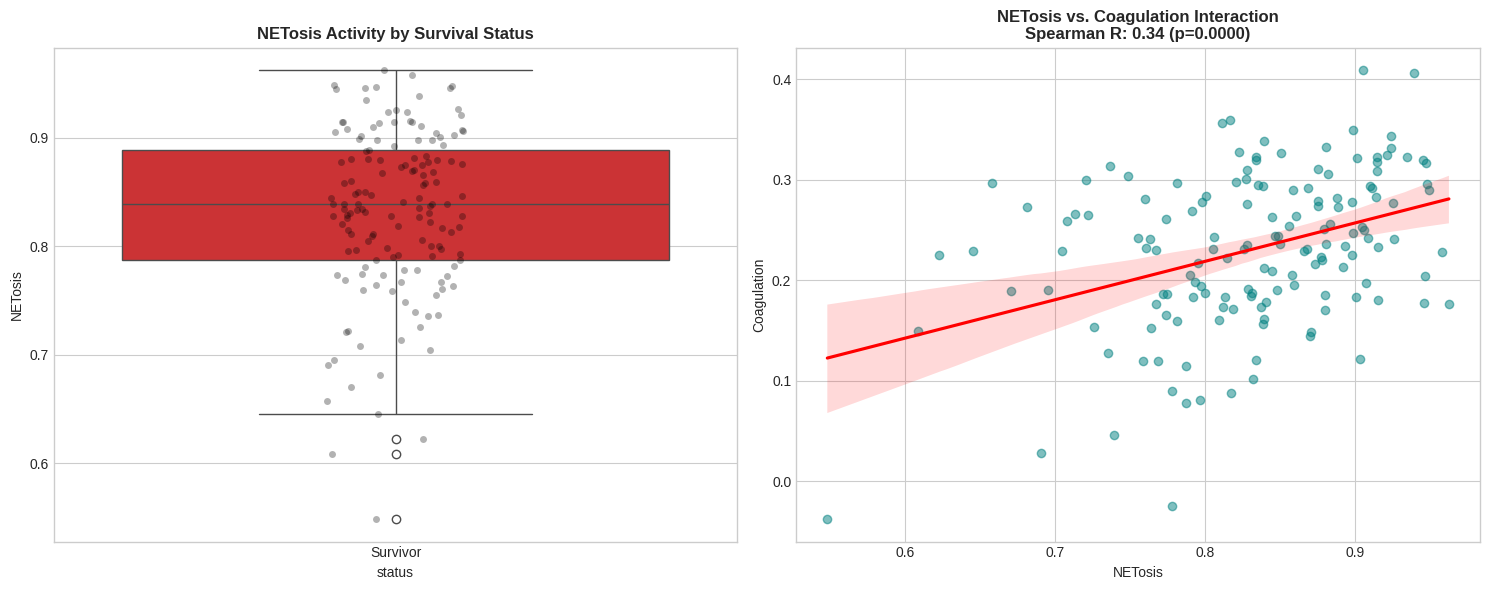

✅ Analysis Complete!
Final dataset contains 149 samples.


In [7]:
import GEOparse
import gseapy as gp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

# 1. Setup
gse_id = "GSE69686"
netosis_genes = ['PADI4' , 'CYBB', 'ELANE', 'MPO', 'CLEC7A', 'MAP2K1', 'RAF1']
coagulation_genes = ['F3', 'SERPINE1', 'PLAT', 'F2R', 'PLAUR', 'THBS1']

print(f"Starting analysis for {gse_id}...")

# 2. Data Acquisition
gse = GEOparse.get_GEO(geo=gse_id, destdir="./", silent=True)
expr_matrix = gse.pivot_samples('VALUE')
metadata = gse.phenotype_data.copy()

# 3. Metadata Harmonization
def harmonizer(row):
    text = "".join(row.astype(str)).lower()
    if any(word in text for word in ['died', 'death','nonsurvivor', 'expired']):
        return 'NonSurvivor'
    return 'Survivor'

metadata['status'] = metadata.apply(harmonizer, axis=1)

# 4. Final Corrected Mapping for GSE69686
gpl_id = list(gse.gpls.keys())[0]
platform_table = gse.gpls[gpl_id].table

# Based on your output, the column name is exactly 'symbol'
symbol_col = 'symbol'

mapping = {}
for _, row in platform_table.iterrows():
    raw_val = str(row[symbol_col])
    # Clean up and ensure it's uppercase to match your gene lists
    clean_symbol = raw_val.strip().upper()
    mapping[str(row['ID'])] = clean_symbol

# Apply the mapping to the matrix
new_index = []
for probe_id in expr_matrix.index:
    gene_symbol = mapping.get(str(probe_id), "UNKNOWN")
    new_index.append(gene_symbol)

expr_matrix.index = new_index

# Filter out the junk (like '---', 'UNKNOWN', or empty values)
expr_matrix = expr_matrix[~expr_matrix.index.isin(["UNKNOWN", "---", "NAN", "NULL", ""])]

print(f"Success! Matrix now has {expr_matrix.shape[0]} valid gene rows.")
print(f"Sample genes: {expr_matrix.index[:5].tolist()}")

# Check if our target genes are actually there
test_genes = [g for g in netosis_genes if g.upper() in expr_matrix.index]
print(f"Target genes found in data: {test_genes}")


# 5. Pathway Scoring (ssGSEA)
print("Calculating pathway scores... this may take a moment.")
ssgsea_obj = gp.ssgsea(
    data=expr_matrix,
    gene_sets={
        'NETosis': [g.upper() for g in netosis_genes],
        'Coagulation' : [g.upper() for g in coagulation_genes]
    },
    sample_norm_method='rank',
    min_size=1,
    max_size=5000,
    outdir=None
)

# 6. Extraction (FIXED: Handling 'Names' vs 'Name' vs Index)
res_df = ssgsea_obj.res2d

# Let's find the sample name column automatically
sample_col = None
for col in ['Names', 'Name', 'Sample', 'index']:
    if col in res_df.columns:
        sample_col = col
        break

if sample_col is None:
    # If no column name matches, the samples are likely in the index
    res_df = res_df.reset_index()
    sample_col = 'index'

# Pivot the results
scores_df = res_df.pivot(index=sample_col, columns='Term', values='NES')

# 7. Integration & Cleanup
final_df = metadata.merge(scores_df, left_index=True, right_index=True)
final_df['NETosis'] = pd.to_numeric(final_df['NETosis'], errors='coerce')
final_df['Coagulation'] = pd.to_numeric(final_df['Coagulation'], errors='coerce')
final_df = final_df.dropna(subset=['NETosis', 'Coagulation'])

# 8. Statistics
from scipy.stats import spearmanr
corr_coeff, p_corr = spearmanr(final_df['NETosis'], final_df['Coagulation'])

# 9. Visualization
plt.style.use('seaborn-v0_8-whitegrid') # Makes it look professional
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot A: NETosis by Outcome
sns.boxplot(data=final_df, x='status', y='NETosis', hue='status', palette='Set1', legend=False, ax=ax1)
sns.stripplot(data=final_df, x='status', y='NETosis', color='black', alpha=0.3, ax=ax1)
ax1.set_title("NETosis Activity by Survival Status", fontweight='bold')

# Plot B: Pathway Interaction
sns.regplot(data=final_df, x='NETosis', y='Coagulation',
            scatter_kws={'alpha':0.5, 'color':'teal'},
            line_kws={'color':'red'}, ax=ax2)
ax2.set_title(f"NETosis vs. Coagulation Interaction\nSpearman R: {corr_coeff:.2f} (p={p_corr:.4f})", fontweight='bold')

plt.tight_layout()
plt.show()

print(f"✅ Analysis Complete!")
print(f"Final dataset contains {len(final_df)} samples.")

Enter GSE ID (e.g., GSE69686): GSE69686

🚀 Starting Universal Analysis for GSE69686...


2026-01-20 07:29:32,189 [WARNING] Found duplicated gene names, values averaged by gene names!


Running ssGSEA...


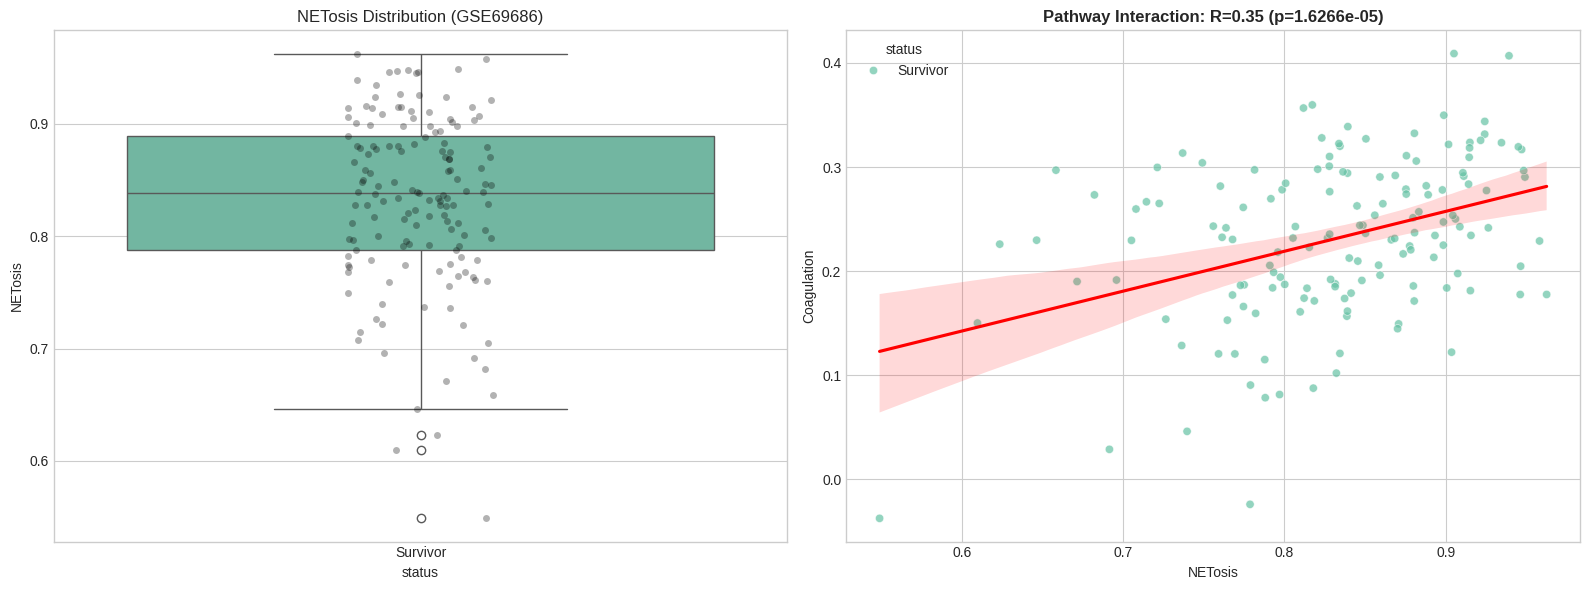


🔥 Generating Heatmap of individual genes...


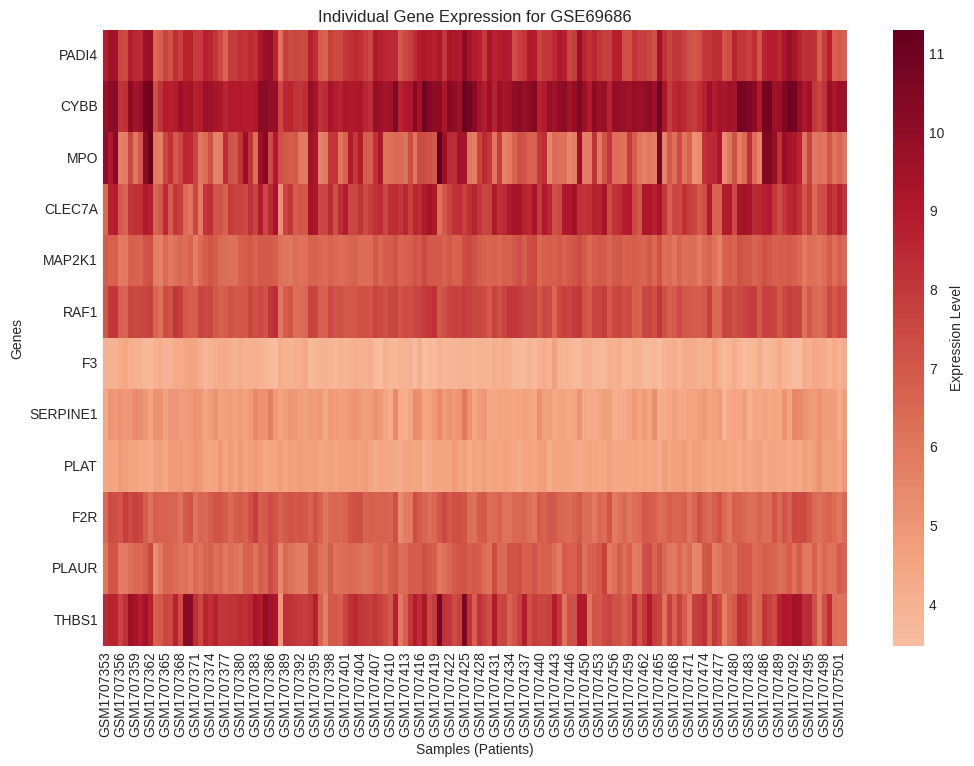

In [21]:
import GEOparse
import gseapy as gp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import os

# --- 1. USER INPUT ---
gse_id = input("Enter GSE ID (e.g., GSE69686): ").strip()

netosis_genes = ['PADI4' , 'CYBB', 'ELANE', 'MPO', 'CLEC7A', 'MAP2K1', 'RAF1']
coagulation_genes = ['F3', 'SERPINE1', 'PLAT', 'F2R', 'PLAUR', 'THBS1']

print(f"\n🚀 Starting Universal Analysis for {gse_id}...")

# --- 2. DATA ACQUISITION ---
try:
    gse = GEOparse.get_GEO(geo=gse_id, destdir="./", silent=True)
    metadata = gse.phenotype_data.copy()
    expr_matrix = gse.pivot_samples('VALUE')
    if expr_matrix.empty or expr_matrix.shape[0] == 0:
        raise ValueError("Matrix is empty.")
except Exception as e:
    print(f"⚠️ Standard import failed. Checking for uploaded files...")
    files = [f for f in os.listdir() if f.startswith(gse_id) and (f.endswith('.gz') or f.endswith('.csv'))]
    if files:
        target = files[0]
        print(f"✅ Found supplementary file: {target}. Loading...")
        expr_matrix = pd.read_csv(target, index_col=0)
    else:
        print(f"❌ Error: Please upload the expression file for {gse_id} to the sidebar.")
        raise ImportError("Data not found.")

# --- 3. SMART GENE MAPPING ---
if not any(gene in expr_matrix.index for gene in netosis_genes):
    try:
        gpl_id = list(gse.gpls.keys())[0]
        df_gpl = gse.gpls[gpl_id].table
        symbol_col = next((c for c in ['symbol', 'Gene Symbol', 'OLIGOTARGET', 'gene_assignment'] if c in df_gpl.columns), None)
        if symbol_col:
            mapping = df_gpl.set_index('ID')[symbol_col].to_dict()
            expr_matrix.index = [str(mapping.get(str(i), i)).split('//')[0].strip().upper() for i in expr_matrix.index]
    except:
        pass

expr_matrix = expr_matrix[~expr_matrix.index.isin(["UNKNOWN", "NAN", "---", ""])]
expr_matrix.index = expr_matrix.index.astype(str).str.upper()

# --- 4. ssGSEA ---
print("Running ssGSEA...")
ss = gp.ssgsea(
    data=expr_matrix,
    gene_sets={'NETosis': netosis_genes, 'Coagulation': coagulation_genes},
    sample_norm_method='rank', min_size=1, outdir=None
)

res = ss.res2d
s_col = next(c for c in ['Names', 'Name', 'Sample'] if c in res.columns)
scores = res.pivot(index=s_col, columns='Term', values='NES')

# --- 5. DATA TYPE FIX (The fix for your error) ---
# This forces the scores to be numbers instead of "objects"
scores['NETosis'] = pd.to_numeric(scores['NETosis'], errors='coerce')
scores['Coagulation'] = pd.to_numeric(scores['Coagulation'], errors='coerce')

# Harmonize Metadata
# FIND THIS SECTION IN YOUR UNIVERSAL CODE AND REPLACE IT:
def harmonizer(row):
    text = " ".join(row.astype(str)).lower()

    # Check for infection status instead of just survival
    if 'sepsis' in text:
        return 'Sepsis'
    if 'uninfected' in text or 'control' in text or 'healthy' in text:
        return 'Healthy'

    # Fallback for other datasets
    if any(word in text for word in ['death', 'died', 'nonsurvivor']):
        return 'NonSurvivor'

    return 'Survivor'

# The line below it stays the same:
metadata['status'] = metadata.apply(harmonizer, axis=1)

import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import mannwhitneyu

# --- 6. ADVANCED VISUALIZATION (Comparative Analysis) ---

# A. Prepare the Layout
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# B. The Grouped Boxplot (Sepsis vs Healthy)
sns.boxplot(data=final_df, x='status', y='NETosis', hue='status', palette='Set2', ax=ax1)
sns.stripplot(data=final_df, x='status', y='NETosis', color='black', alpha=0.3, ax=ax1)

# Stats: Only run if we have 2 groups
groups = final_df['status'].unique()
if len(groups) >= 2:
    g1 = final_df[final_df['status'] == groups[0]]['NETosis']
    g2 = final_df[final_df['status'] == groups[1]]['NETosis']
    stat, p_val = mannwhitneyu(g1, g2)
    ax1.set_title(f"NETosis Score: {groups[0]} vs {groups[1]}\np-value: {p_val:.4e}", fontweight='bold')
else:
    ax1.set_title(f"NETosis Distribution ({gse_id})")

# C. The Colored Interaction Plot
# This colors the dots by Sepsis/Healthy status
sns.scatterplot(data=final_df, x='NETosis', y='Coagulation', hue='status', palette='Set2', alpha=0.7, ax=ax2)
sns.regplot(data=final_df, x='NETosis', y='Coagulation', scatter=False, color='red', ax=ax2)

r, p = stats.spearmanr(final_df['NETosis'], final_df['Coagulation'])
ax2.set_title(f"Pathway Interaction: R={r:.2f} (p={p:.4e})", fontweight='bold')

plt.tight_layout()
plt.show()

# --- 7. GENE-LEVEL HEATMAP ---
# Let's see how the individual genes are behaving
print("\n🔥 Generating Heatmap of individual genes...")
selected_genes = [g for g in netosis_genes + coagulation_genes if g in expr_matrix.index]
heatmap_data = expr_matrix.loc[selected_genes]

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='RdBu_r', center=0, cbar_kws={'label': 'Expression Level'})
plt.title(f"Individual Gene Expression for {gse_id}")
plt.xlabel("Samples (Patients)")
plt.ylabel("Genes")
plt.show()

In [15]:
print(metadata.iloc[:, :10].head())

           title geo_accession    status submission_date last_update_date  \
GSM1707353    9A    GSM1707353  Survivor     Jun 09 2015      Jul 06 2015   
GSM1707354    9B    GSM1707354  Survivor     Jun 09 2015      Jul 06 2015   
GSM1707355    9C    GSM1707355  Survivor     Jun 09 2015      Jul 06 2015   
GSM1707356   10A    GSM1707356  Survivor     Jun 09 2015      Jul 06 2015   
GSM1707357   10B    GSM1707357  Survivor     Jun 09 2015      Jul 06 2015   

           type channel_count                    source_name_ch1  \
GSM1707353  RNA             1  EARLY_clinical sepsis_whole blood   
GSM1707354  RNA             1  EARLY_clinical sepsis_whole blood   
GSM1707355  RNA             1  EARLY_clinical sepsis_whole blood   
GSM1707356  RNA             1       EARLY_uninfected_whole blood   
GSM1707357  RNA             1       EARLY_uninfected_whole blood   

            organism_ch1 taxid_ch1  
GSM1707353  Homo sapiens      9606  
GSM1707354  Homo sapiens      9606  
GSM1707355  Homo 